In [ ]:
import requests
import json
import time
import datetime
from urllib.request import urlopen
import requests
import warnings
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns
#import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import nearest_points

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from pyproj import CRS
import os
#import movingpandas as mpd
from shapely.geometry import Point

In [ ]:
# Read the CSV file into a DataFrame
halifax_gps = pd.read_csv('Halifax_export.csv')
halifax_gps.head()

,Unnamed: 0,DateTime,registrationID,latitude,longitude,recordCount
0,172379,2023-05-29 00:50:14,74c83e3e-c66d-39fc-99bc-deeeae8cf508,44.781195,-63.720366,3
1,172380,2023-05-24 15:43:14,1951e47f-8b08-3ac6-a227-17ad808e88ca,44.781250,-63.720140,2
2,172381,2023-05-24 15:43:03,1951e47f-8b08-3ac6-a227-17ad808e88ca,44.781290,-63.720100,4
3,172382,2023-05-24 15:43:54,1951e47f-8b08-3ac6-a227-17ad808e88ca,44.781290,-63.720100,4
4,172383,2023-05-24 09:15:41,7851703c-085a-3c1e-915f-739c178d0c96,44.781460,-63.720280,4


In [ ]:
# Create a geometry column from latitude and longitude and create gdf for Halifax
geometry = [Point(xy) for xy in zip(halifax_gps['longitude'], halifax_gps['latitude'])]
halifax_gps = gpd.GeoDataFrame(halifax_gps, geometry=geometry)

halifax_gps.set_crs(epsg=4326, inplace=True)  # WGS 84
halifax_gps.head()

,Unnamed: 0,DateTime,registrationID,latitude,longitude,recordCount,geometry
0,172379,2023-05-29 00:50:14,74c83e3e-c66d-39fc-99bc-deeeae8cf508,44.781195,-63.720366,3,POINT (-63.72037 44.7812)
1,172380,2023-05-24 15:43:14,1951e47f-8b08-3ac6-a227-17ad808e88ca,44.781250,-63.720140,2,POINT (-63.72014 44.78125)
2,172381,2023-05-24 15:43:03,1951e47f-8b08-3ac6-a227-17ad808e88ca,44.781290,-63.720100,4,POINT (-63.7201 44.78129)
3,172382,2023-05-24 15:43:54,1951e47f-8b08-3ac6-a227-17ad808e88ca,44.781290,-63.720100,4,POINT (-63.7201 44.78129)
4,172383,2023-05-24 09:15:41,7851703c-085a-3c1e-915f-739c178d0c96,44.781460,-63.720280,4,POINT (-63.72028 44.78146)


In [ ]:
# Ensure the DateTime column is in datetime format
halifax_gps['DateTime'] = pd.to_datetime(halifax_gps['DateTime'])

start_time_h = halifax_gps['DateTime'].min()
end_time_h = halifax_gps['DateTime'].max()
print(f"Halifax data was collected from {start_time_h} to {end_time_h}.")

Halifax data was collected from 2023-05-24 00:00:00 to 2023-05-30 23:59:59.


In [ ]:
# Make new df within specified datetime
halifax_gps_24May_30May = halifax_gps[(halifax_gps['DateTime']>'2023-05-24') & (halifax_gps['DateTime']<'2023-05-31')]
## halifax_gps_31May_06Jun = halifax_gps[(halifax_gps['DateTime']>'2023-05-31') & (halifax_gps['DateTime']<'2023-06-07')]
## halifax_gps_07Jun_13Jun = halifax_gps[(halifax_gps['DateTime']>'2023-06-07') & (halifax_gps['DateTime']<'2023-06-14')]
## halifax_gps_14Jun_20Jun = halifax_gps[(halifax_gps['DateTime']>'2023-06-14') & (halifax_gps['DateTime']<'2023-06-21')]
## halifax_gps_21Jun_27Jun = halifax_gps[(halifax_gps['DateTime']>'2023-06-21') & (halifax_gps['DateTime']<'2023-06-28')]
## halifax_gps_28Jun_04Jul = halifax_gps[(halifax_gps['DateTime']>'2023-06-28') & (halifax_gps['DateTime']<'2023-07-05')]
## halifax_gps_05Jul_11Jul = halifax_gps[(halifax_gps['DateTime']>'2023-07-05') & (halifax_gps['DateTime']<'2023-07-12')]
## halifax_gps_12Jul_18Jul = halifax_gps[(halifax_gps['DateTime']>'2023-07-12') & (halifax_gps['DateTime']<'2023-07-19')]
## halifax_gps_19Jul_28Jul = halifax_gps[(halifax_gps['DateTime']>'2023-07-19') & (halifax_gps['DateTime']<'2023-07-29')]

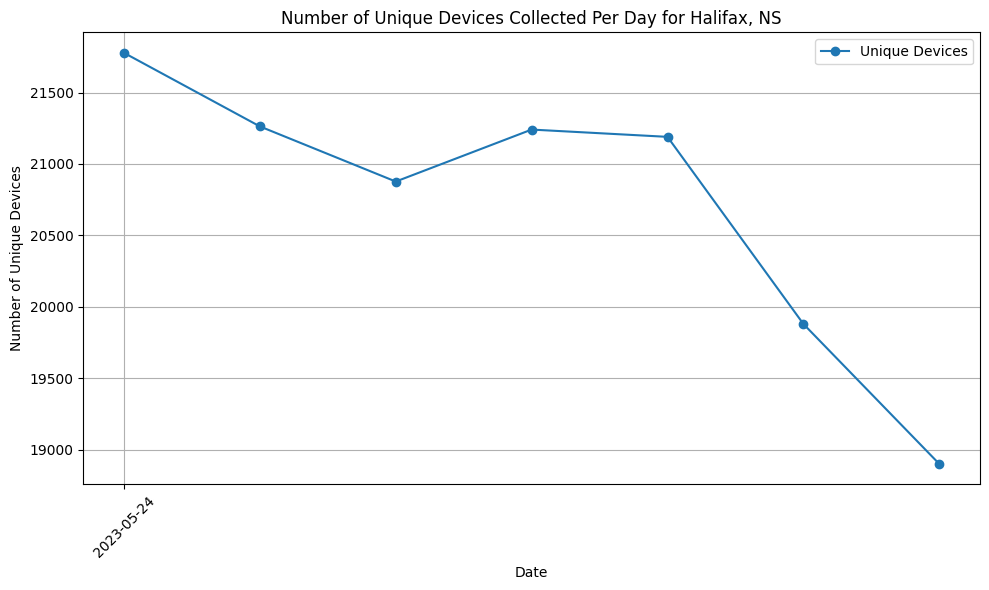

In [ ]:
# Extract the date from DateTime
halifax_gps['Date'] = halifax_gps['DateTime'].dt.date

daily_unique_devices_h = (
    halifax_gps.groupby('Date')['registrationID']
    .nunique()
    .reset_index(name='UniqueDevices')
)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(daily_unique_devices_h['Date'], daily_unique_devices_h['UniqueDevices'], marker='o', label='Unique Devices')
plt.xticks(daily_unique_devices_h['Date'][::7], rotation=45)

plt.xlabel('Date')
plt.ylabel('Number of Unique Devices')
plt.title('Number of Unique Devices Collected Per Day for Halifax, NS')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Read highway shapefiles
halifax_ns101_shp = gpd.read_file('ns_gis/NS101_East_1kmBuffer.shp')
halifax_ns101_shp.to_crs(epsg=4326, inplace=True)

halifax_ns103_shp = gpd.read_file('ns_gis/NS103_East_1kmBuffer.shp')
halifax_ns103_shp.to_crs(epsg=4326, inplace=True)

In [ ]:
# Spatial join for NS101 for the remaining gdfs
halifax_gps_31May_06Jun_ns101 = gpd.sjoin(halifax_gps_31May_06Jun, halifax_ns101_shp, how='inner', predicate='intersects')
halifax_gps_07Jun_13Jun_ns101 = gpd.sjoin(halifax_gps_07Jun_13Jun, halifax_ns101_shp, how='inner', predicate='intersects')
halifax_gps_14Jun_20Jun_ns101 = gpd.sjoin(halifax_gps_14Jun_20Jun, halifax_ns101_shp, how='inner', predicate='intersects')
halifax_gps_21Jun_27Jun_ns101 = gpd.sjoin(halifax_gps_21Jun_27Jun, halifax_ns101_shp, how='inner', predicate='intersects')
halifax_gps_28Jun_04Jul_ns101 = gpd.sjoin(halifax_gps_28Jun_04Jul, halifax_ns101_shp, how='inner', predicate='intersects')
halifax_gps_05Jul_11Jul_ns101 = gpd.sjoin(halifax_gps_05Jul_11Jul, halifax_ns101_shp, how='inner', predicate='intersects')
halifax_gps_12Jul_18Jul_ns101 = gpd.sjoin(halifax_gps_12Jul_18Jul, halifax_ns101_shp, how='inner', predicate='intersects')
halifax_gps_19Jul_28Jul_ns101 = gpd.sjoin(halifax_gps_19Jul_28Jul, halifax_ns101_shp, how='inner', predicate='intersects')

# Spatial join for NS103 for the remaining gdfs
halifax_gps_31May_06Jun_ns103 = gpd.sjoin(halifax_gps_31May_06Jun, halifax_ns103_shp, how='inner', predicate='intersects')
halifax_gps_07Jun_13Jun_ns103 = gpd.sjoin(halifax_gps_07Jun_13Jun, halifax_ns103_shp, how='inner', predicate='intersects')
halifax_gps_14Jun_20Jun_ns103 = gpd.sjoin(halifax_gps_14Jun_20Jun, halifax_ns103_shp, how='inner', predicate='intersects')
halifax_gps_21Jun_27Jun_ns103 = gpd.sjoin(halifax_gps_21Jun_27Jun, halifax_ns103_shp, how='inner', predicate='intersects')
halifax_gps_28Jun_04Jul_ns103 = gpd.sjoin(halifax_gps_28Jun_04Jul, halifax_ns103_shp, how='inner', predicate='intersects')
halifax_gps_05Jul_11Jul_ns103 = gpd.sjoin(halifax_gps_05Jul_11Jul, halifax_ns103_shp, how='inner', predicate='intersects')
halifax_gps_12Jul_18Jul_ns103 = gpd.sjoin(halifax_gps_12Jul_18Jul, halifax_ns103_shp, how='inner', predicate='intersects')
halifax_gps_19Jul_28Jul_ns103 = gpd.sjoin(halifax_gps_19Jul_28Jul, halifax_ns103_shp, how='inner', predicate='intersects')


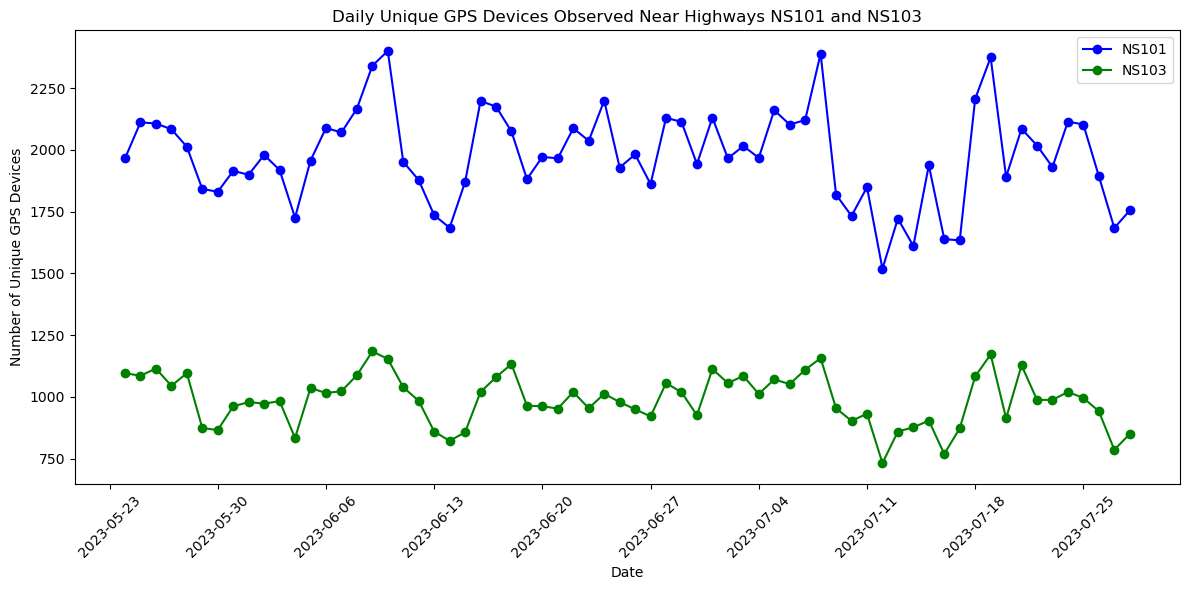

In [ ]:
# Function to calculate daily counts of unique devices for a given DataFrame
def calculate_daily_unique_devices(weekly_gps):
    weekly_gps['DateTime'] = pd.to_datetime(weekly_gps['DateTime'])
    daily_unique = weekly_gps.groupby(weekly_gps['DateTime'].dt.date)['registrationID'].nunique()
    return daily_unique

ns101_weekly_unique_devices = []
for weekly_df in [
    halifax_gps_24May_30May_ns101,
    halifax_gps_31May_06Jun_ns101,
    halifax_gps_07Jun_13Jun_ns101,
    halifax_gps_14Jun_20Jun_ns101,
    halifax_gps_21Jun_27Jun_ns101,
    halifax_gps_28Jun_04Jul_ns101,
    halifax_gps_05Jul_11Jul_ns101,
    halifax_gps_12Jul_18Jul_ns101,
    halifax_gps_19Jul_28Jul_ns101
]:
    ns101_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

ns103_weekly_unique_devices = []
for weekly_df in [
    halifax_gps_24May_30May_ns103,
    halifax_gps_31May_06Jun_ns103,
    halifax_gps_07Jun_13Jun_ns103,
    halifax_gps_14Jun_20Jun_ns103,
    halifax_gps_21Jun_27Jun_ns103,
    halifax_gps_28Jun_04Jul_ns103,
    halifax_gps_05Jul_11Jul_ns103,
    halifax_gps_12Jul_18Jul_ns103,
    halifax_gps_19Jul_28Jul_ns103
]:
    ns103_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

ns101_daily_unique_devices = pd.concat(ns101_weekly_unique_devices).groupby(level=0).sum()
ns103_daily_unique_devices = pd.concat(ns103_weekly_unique_devices).groupby(level=0).sum()

daily_unique_devices = pd.DataFrame({
    'NS101': ns101_daily_unique_devices,
    'NS103': ns103_daily_unique_devices
}).fillna(0)

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))

daily_unique_devices['NS101'].plot(ax=ax, label='NS101', color='blue', marker='o')
daily_unique_devices['NS103'].plot(ax=ax, label='NS103', color='green', marker='o')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Unique GPS Devices')
ax.set_title('Daily Unique GPS Devices Observed Near Highways NS101 and NS103')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
ns_communities_shp = gpd.read_file('BND_NS_Community_Bndys_UT83v6.shp')

ham_plains_shp = ns_communities_shp[ns_communities_shp['GSA_NAME'] == 'Hammonds Plains']
lucasville_shp = ns_communities_shp[ns_communities_shp['GSA_NAME'] == 'Lucasville']
upr_sville_shp = ns_communities_shp[ns_communities_shp['GSA_NAME'] == 'Upper Sackville']
mid_sville_shp = ns_communities_shp[ns_communities_shp['GSA_NAME'] == 'Middle Sackville']
low_sville_shp = ns_communities_shp[ns_communities_shp['GSA_NAME'] == 'Lower Sackville']

,OBJECTID,GSA_KEY,GSA_CODE,GSA_NAME,CO_CODE,MUN_ID,EDIT_V,RETIRED,VERIFIED,LOCKED,MUN_CODE,geometry
2260,269269,3061,GCAPJF,Hammonds Plains,HX,88,0,N,N,N,HX,"POLYGON ((443574.153 4954885.338, 443150.033 4..."


In [ ]:
# Spatial join for GPS entries inside Hammonds Plains for the gdfs
halifax_gps_24May_30May_ham_plains = gpd.sjoin(halifax_gps_24May_30May, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_31May_06Jun_ham_plains = gpd.sjoin(halifax_gps_31May_06Jun, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_07Jun_13Jun_ham_plains = gpd.sjoin(halifax_gps_07Jun_13Jun, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_14Jun_20Jun_ham_plains = gpd.sjoin(halifax_gps_14Jun_20Jun, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_21Jun_27Jun_ham_plains = gpd.sjoin(halifax_gps_21Jun_27Jun, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_28Jun_04Jul_ham_plains = gpd.sjoin(halifax_gps_28Jun_04Jul, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_05Jul_11Jul_ham_plains = gpd.sjoin(halifax_gps_05Jul_11Jul, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_12Jul_18Jul_ham_plains = gpd.sjoin(halifax_gps_12Jul_18Jul, ham_plains_shp, how='inner', predicate='intersects')
halifax_gps_19Jul_28Jul_ham_plains = gpd.sjoin(halifax_gps_19Jul_28Jul, ham_plains_shp, how='inner', predicate='intersects')

halifax_gps_24May_30May_lucasville = gpd.sjoin(halifax_gps_24May_30May, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_31May_06Jun_lucasville = gpd.sjoin(halifax_gps_31May_06Jun, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_07Jun_13Jun_lucasville = gpd.sjoin(halifax_gps_07Jun_13Jun, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_14Jun_20Jun_lucasville = gpd.sjoin(halifax_gps_14Jun_20Jun, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_21Jun_27Jun_lucasville = gpd.sjoin(halifax_gps_21Jun_27Jun, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_28Jun_04Jul_lucasville = gpd.sjoin(halifax_gps_28Jun_04Jul, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_05Jul_11Jul_lucasville = gpd.sjoin(halifax_gps_05Jul_11Jul, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_12Jul_18Jul_lucasville = gpd.sjoin(halifax_gps_12Jul_18Jul, lucasville_shp, how='inner', predicate='intersects')
halifax_gps_19Jul_28Jul_lucasville = gpd.sjoin(halifax_gps_19Jul_28Jul, lucasville_shp, how='inner', predicate='intersects')

halifax_gps_24May_30May_upr_sville = gpd.sjoin(halifax_gps_24May_30May, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_31May_06Jun_upr_sville = gpd.sjoin(halifax_gps_31May_06Jun, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_07Jun_13Jun_upr_sville = gpd.sjoin(halifax_gps_07Jun_13Jun, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_14Jun_20Jun_upr_sville = gpd.sjoin(halifax_gps_14Jun_20Jun, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_21Jun_27Jun_upr_sville = gpd.sjoin(halifax_gps_21Jun_27Jun, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_28Jun_04Jul_upr_sville = gpd.sjoin(halifax_gps_28Jun_04Jul, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_05Jul_11Jul_upr_sville = gpd.sjoin(halifax_gps_05Jul_11Jul, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_12Jul_18Jul_upr_sville = gpd.sjoin(halifax_gps_12Jul_18Jul, upr_sville_shp, how='inner', predicate='intersects')
halifax_gps_19Jul_28Jul_upr_sville = gpd.sjoin(halifax_gps_19Jul_28Jul, upr_sville_shp, how='inner', predicate='intersects')

halifax_gps_24May_30May_mid_sville = gpd.sjoin(halifax_gps_24May_30May, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_31May_06Jun_mid_sville = gpd.sjoin(halifax_gps_31May_06Jun, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_07Jun_13Jun_mid_sville = gpd.sjoin(halifax_gps_07Jun_13Jun, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_14Jun_20Jun_mid_sville = gpd.sjoin(halifax_gps_14Jun_20Jun, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_21Jun_27Jun_mid_sville = gpd.sjoin(halifax_gps_21Jun_27Jun, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_28Jun_04Jul_mid_sville = gpd.sjoin(halifax_gps_28Jun_04Jul, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_05Jul_11Jul_mid_sville = gpd.sjoin(halifax_gps_05Jul_11Jul, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_12Jul_18Jul_mid_sville = gpd.sjoin(halifax_gps_12Jul_18Jul, mid_sville_shp, how='inner', predicate='intersects')
halifax_gps_19Jul_28Jul_mid_sville = gpd.sjoin(halifax_gps_19Jul_28Jul, mid_sville_shp, how='inner', predicate='intersects')

halifax_gps_24May_30May_low_sville = gpd.sjoin(halifax_gps_24May_30May, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_31May_06Jun_low_sville = gpd.sjoin(halifax_gps_31May_06Jun, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_07Jun_13Jun_low_sville = gpd.sjoin(halifax_gps_07Jun_13Jun, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_14Jun_20Jun_low_sville = gpd.sjoin(halifax_gps_14Jun_20Jun, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_21Jun_27Jun_low_sville = gpd.sjoin(halifax_gps_21Jun_27Jun, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_28Jun_04Jul_low_sville = gpd.sjoin(halifax_gps_28Jun_04Jul, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_05Jul_11Jul_low_sville = gpd.sjoin(halifax_gps_05Jul_11Jul, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_12Jul_18Jul_low_sville = gpd.sjoin(halifax_gps_12Jul_18Jul, low_sville_shp, how='inner', predicate='intersects')
halifax_gps_19Jul_28Jul_low_sville = gpd.sjoin(halifax_gps_19Jul_28Jul, low_sville_shp, how='inner', predicate='intersects')


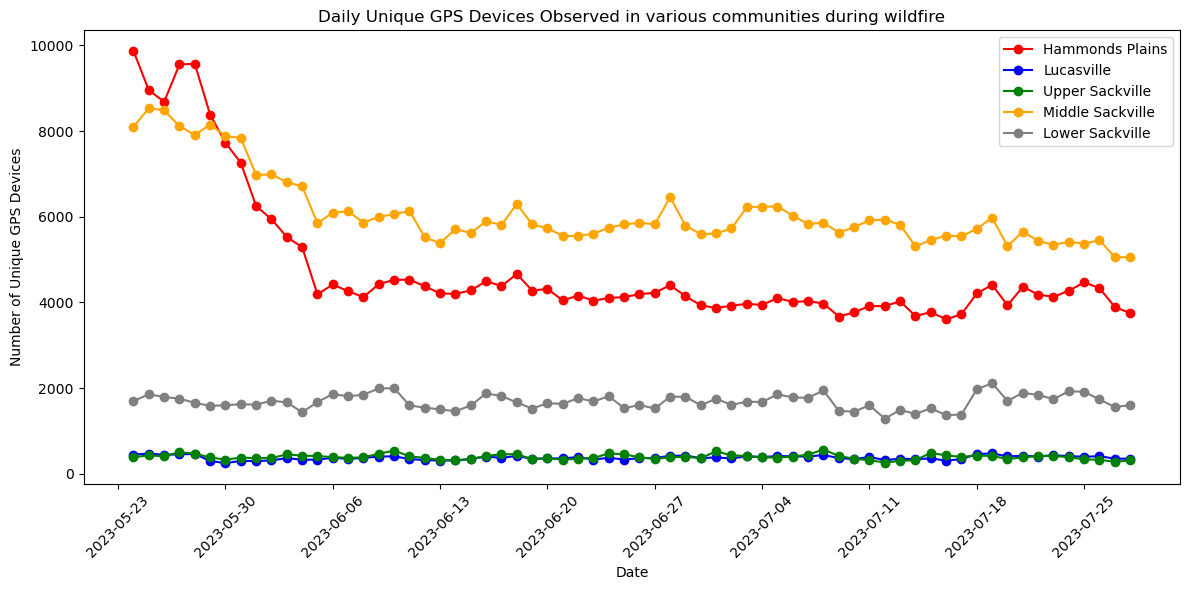

In [ ]:
# Process Hammonds Plains week-by-week for unique devices
ham_plains_weekly_unique_devices = []
for weekly_df in [
    halifax_gps_24May_30May_ham_plains,
    halifax_gps_31May_06Jun_ham_plains,
    halifax_gps_07Jun_13Jun_ham_plains,
    halifax_gps_14Jun_20Jun_ham_plains,
    halifax_gps_21Jun_27Jun_ham_plains,
    halifax_gps_28Jun_04Jul_ham_plains,
    halifax_gps_05Jul_11Jul_ham_plains,
    halifax_gps_12Jul_18Jul_ham_plains,
    halifax_gps_19Jul_28Jul_ham_plains
]:
    ham_plains_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

lucasville_weekly_unique_devices = []
for weekly_df in [
    halifax_gps_24May_30May_lucasville,
    halifax_gps_31May_06Jun_lucasville,
    halifax_gps_07Jun_13Jun_lucasville,
    halifax_gps_14Jun_20Jun_lucasville,
    halifax_gps_21Jun_27Jun_lucasville,
    halifax_gps_28Jun_04Jul_lucasville,
    halifax_gps_05Jul_11Jul_lucasville,
    halifax_gps_12Jul_18Jul_lucasville,
    halifax_gps_19Jul_28Jul_lucasville
]:
    lucasville_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

upr_sville_weekly_unique_devices = []
for weekly_df in [
    halifax_gps_24May_30May_upr_sville,
    halifax_gps_31May_06Jun_upr_sville,
    halifax_gps_07Jun_13Jun_upr_sville,
    halifax_gps_14Jun_20Jun_upr_sville,
    halifax_gps_21Jun_27Jun_upr_sville,
    halifax_gps_28Jun_04Jul_upr_sville,
    halifax_gps_05Jul_11Jul_upr_sville,
    halifax_gps_12Jul_18Jul_upr_sville,
    halifax_gps_19Jul_28Jul_upr_sville
]:
    upr_sville_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

mid_sville_weekly_unique_devices = []
for weekly_df in [
    halifax_gps_24May_30May_mid_sville,
    halifax_gps_31May_06Jun_mid_sville,
    halifax_gps_07Jun_13Jun_mid_sville,
    halifax_gps_14Jun_20Jun_mid_sville,
    halifax_gps_21Jun_27Jun_mid_sville,
    halifax_gps_28Jun_04Jul_mid_sville,
    halifax_gps_05Jul_11Jul_mid_sville,
    halifax_gps_12Jul_18Jul_mid_sville,
    halifax_gps_19Jul_28Jul_mid_sville
]:
    mid_sville_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

low_sville_weekly_unique_devices = []
for weekly_df in [
    halifax_gps_24May_30May_low_sville,
    halifax_gps_31May_06Jun_low_sville,
    halifax_gps_07Jun_13Jun_low_sville,
    halifax_gps_14Jun_20Jun_low_sville,
    halifax_gps_21Jun_27Jun_low_sville,
    halifax_gps_28Jun_04Jul_low_sville,
    halifax_gps_05Jul_11Jul_low_sville,
    halifax_gps_12Jul_18Jul_low_sville,
    halifax_gps_19Jul_28Jul_low_sville
]:
    low_sville_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

ham_plains_daily_unique_devices = pd.concat(ham_plains_weekly_unique_devices).groupby(level=0).sum()
lucasville_daily_unique_devices = pd.concat(lucasville_weekly_unique_devices).groupby(level=0).sum()
upr_sville_daily_unique_devices = pd.concat(upr_sville_weekly_unique_devices).groupby(level=0).sum()
mid_sville_daily_unique_devices = pd.concat(mid_sville_weekly_unique_devices).groupby(level=0).sum()
low_sville_daily_unique_devices = pd.concat(low_sville_weekly_unique_devices).groupby(level=0).sum()

daily_unique_devices = pd.DataFrame({
    'Hammonds Plains': ham_plains_daily_unique_devices,
    'Lucasville': lucasville_daily_unique_devices,
    'Upper Sackville': upr_sville_daily_unique_devices,
    'Middle Sackville': mid_sville_daily_unique_devices,
    'Lower Sackville': low_sville_daily_unique_devices
}).fillna(0)

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))

daily_unique_devices['Hammonds Plains'].plot(ax=ax, label='Hammonds Plains', color='red', marker='o')
daily_unique_devices['Lucasville'].plot(ax=ax, label='Lucasville', color='blue', marker='o')
daily_unique_devices['Upper Sackville'].plot(ax=ax, label='Upper Sackville', color='green', marker='o')
daily_unique_devices['Middle Sackville'].plot(ax=ax, label='Middle Sackville', color='orange', marker='o')
daily_unique_devices['Lower Sackville'].plot(ax=ax, label='Lower Sackville', color='grey', marker='o')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Unique GPS Devices')
ax.set_title('Daily Unique GPS Devices Observed in various communities during wildfire')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Function to round DateTime to the nearest 4-hour interval
def add_approx_datetime(dataframe):
    dataframe['DateTime'] = pd.to_datetime(dataframe['DateTime'])  # Ensure DateTime is in datetime format
    dataframe['DateTimeApprox'] = dataframe['DateTime'].dt.round('4h')  # Round to the nearest 4-hour interval
    return dataframe

halifax_gps_24May_30May_ns101 = add_approx_datetime(halifax_gps_24May_30May_ns101)
halifax_gps_24May_30May_ns103 = add_approx_datetime(halifax_gps_24May_30May_ns103)
halifax_gps_24May_30May_ns101.head()

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,F_id,NHS,alt_name,...,bridge,layer,source,bridge_nam,bridge_ref,BUFF_DIST,ORIG_FID,AnalysisAr,time_bin,DateTimeApprox
172379,2023-05-29 00:50:14,74c83e3e-c66d-39fc-99bc-deeeae8cf508,44.781195,-63.720366,3,POINT (-63.72037 44.78119),0,way/4941138,yes,Harvest Highway,...,None,None,None,None,None,1.0,1,6.085975,2023-05-29,2023-05-29
172379,2023-05-29 00:50:14,74c83e3e-c66d-39fc-99bc-deeeae8cf508,44.781195,-63.720366,3,POINT (-63.72037 44.78119),6,way/20232754,yes,Harvest Highway,...,None,None,None,None,None,1.0,7,5.885707,2023-05-29,2023-05-29
172379,2023-05-29 00:50:14,74c83e3e-c66d-39fc-99bc-deeeae8cf508,44.781195,-63.720366,3,POINT (-63.72037 44.78119),7,way/20232758,yes,Harvest Highway,...,yes,1,None,None,None,1.0,8,3.238243,2023-05-29,2023-05-29
172379,2023-05-29 00:50:14,74c83e3e-c66d-39fc-99bc-deeeae8cf508,44.781195,-63.720366,3,POINT (-63.72037 44.78119),2,way/4941140,yes,Harvest Highway,...,yes,1,None,None,None,1.0,3,3.242121,2023-05-29,2023-05-29
172379,2023-05-29 00:50:14,74c83e3e-c66d-39fc-99bc-deeeae8cf508,44.781195,-63.720366,3,POINT (-63.72037 44.78119),3,way/4941141,yes,Harvest Highway,...,None,None,None,None,None,1.0,4,4.465513,2023-05-29,2023-05-29


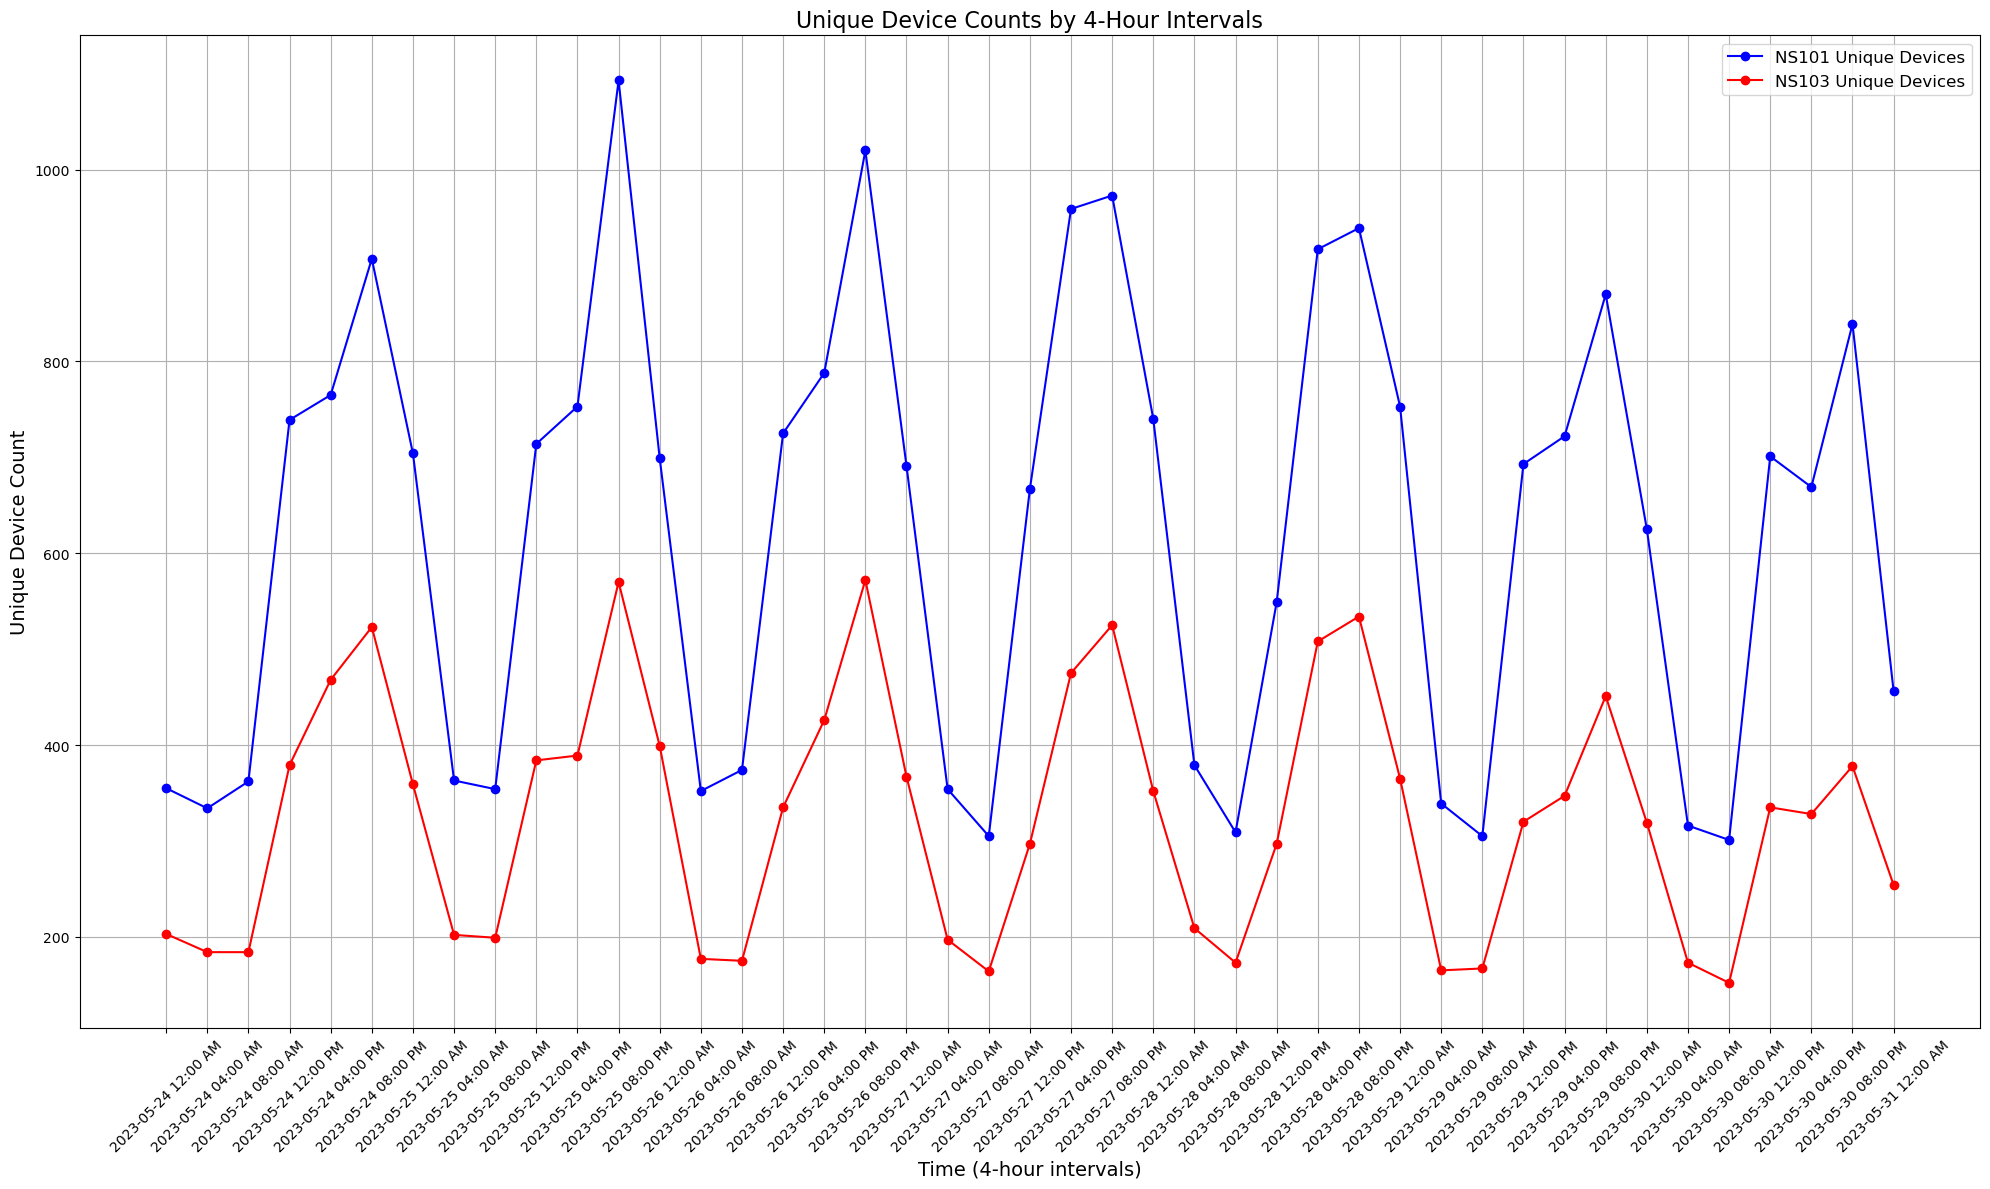

In [ ]:
# Compute unique counts for each dataframe
halifax_gps_24May_30May_ns101_unique_counts = halifax_gps_24May_30May_ns101.groupby('DateTimeApprox')['registrationID'].nunique()
halifax_gps_24May_30May_ns103_unique_counts = halifax_gps_24May_30May_ns103.groupby('DateTimeApprox')['registrationID'].nunique()

plt.figure(figsize=(20, 12))
plt.plot(
    halifax_gps_24May_30May_ns101_unique_counts.index,
    halifax_gps_24May_30May_ns101_unique_counts.values,
    label='NS101 Unique Devices',
    color='blue',
    marker='o'
)
plt.plot(
    halifax_gps_24May_30May_ns103_unique_counts.index,
    halifax_gps_24May_30May_ns103_unique_counts.values,
    label='NS103 Unique Devices',
    color='red',
    marker='o'
)

plt.title("Unique Device Counts by 4-Hour Intervals", fontsize=16)
plt.xlabel('Time (4-hour intervals)', fontsize=14)
plt.ylabel('Unique Device Count', fontsize=14)

plt.xticks(
    halifax_gps_24May_30May_ns101_unique_counts.index,
    halifax_gps_24May_30May_ns101_unique_counts.index.strftime('%Y-%m-%d %I:%M %p'),
    rotation=45,
    fontsize=10
)

plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


In [ ]:
halifax_gps_24May_30May_ham_plains = add_approx_datetime(halifax_gps_24May_30May_ham_plains)
halifax_gps_24May_30May_lucasville = add_approx_datetime(halifax_gps_24May_30May_lucasville)
halifax_gps_24May_30May_upr_sville = add_approx_datetime(halifax_gps_24May_30May_upr_sville)
halifax_gps_24May_30May_mid_sville = add_approx_datetime(halifax_gps_24May_30May_mid_sville)
halifax_gps_24May_30May_low_sville = add_approx_datetime(halifax_gps_24May_30May_low_sville)

# Displaying one sample
halifax_gps_24May_30May_ham_plains.head()

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,OBJECTID,GSA_KEY,GSA_CODE,GSA_NAME,CO_CODE,MUN_ID,EDIT_V,RETIRED,VERIFIED,LOCKED,MUN_CODE,DateTimeApprox
2617206,2023-05-28 16:23:05,03ffcb4e-93a3-3ac2-82a5-6f87e1c74d10,44.737157,-63.806349,2,POINT (-7102890.280 5580236.715),2260,269269,3061,GCAPJF,Hammonds Plains,HX,88,0,N,N,N,HX,2023-05-28 16:00:00
2617207,2023-05-25 18:36:38,fa82261a-9113-3e36-ac0b-4ba00e5346df,44.736908,-63.805216,8,POINT (-7102764.155 5580197.694),2260,269269,3061,GCAPJF,Hammonds Plains,HX,88,0,N,N,N,HX,2023-05-25 20:00:00
2617208,2023-05-25 18:36:48,9a406174-3004-3200-8dc8-200c8e87422f,44.736907,-63.805225,2,POINT (-7102765.157 5580197.537),2260,269269,3061,GCAPJF,Hammonds Plains,HX,88,0,N,N,N,HX,2023-05-25 20:00:00
2617209,2023-05-27 01:11:39,fa82261a-9113-3e36-ac0b-4ba00e5346df,44.736350,-63.804882,4,POINT (-7102726.974 5580110.249),2260,269269,3061,GCAPJF,Hammonds Plains,HX,88,0,N,N,N,HX,2023-05-27 00:00:00
2617210,2023-05-27 01:11:39,9a406174-3004-3200-8dc8-200c8e87422f,44.736350,-63.804882,3,POINT (-7102726.974 5580110.249),2260,269269,3061,GCAPJF,Hammonds Plains,HX,88,0,N,N,N,HX,2023-05-27 00:00:00


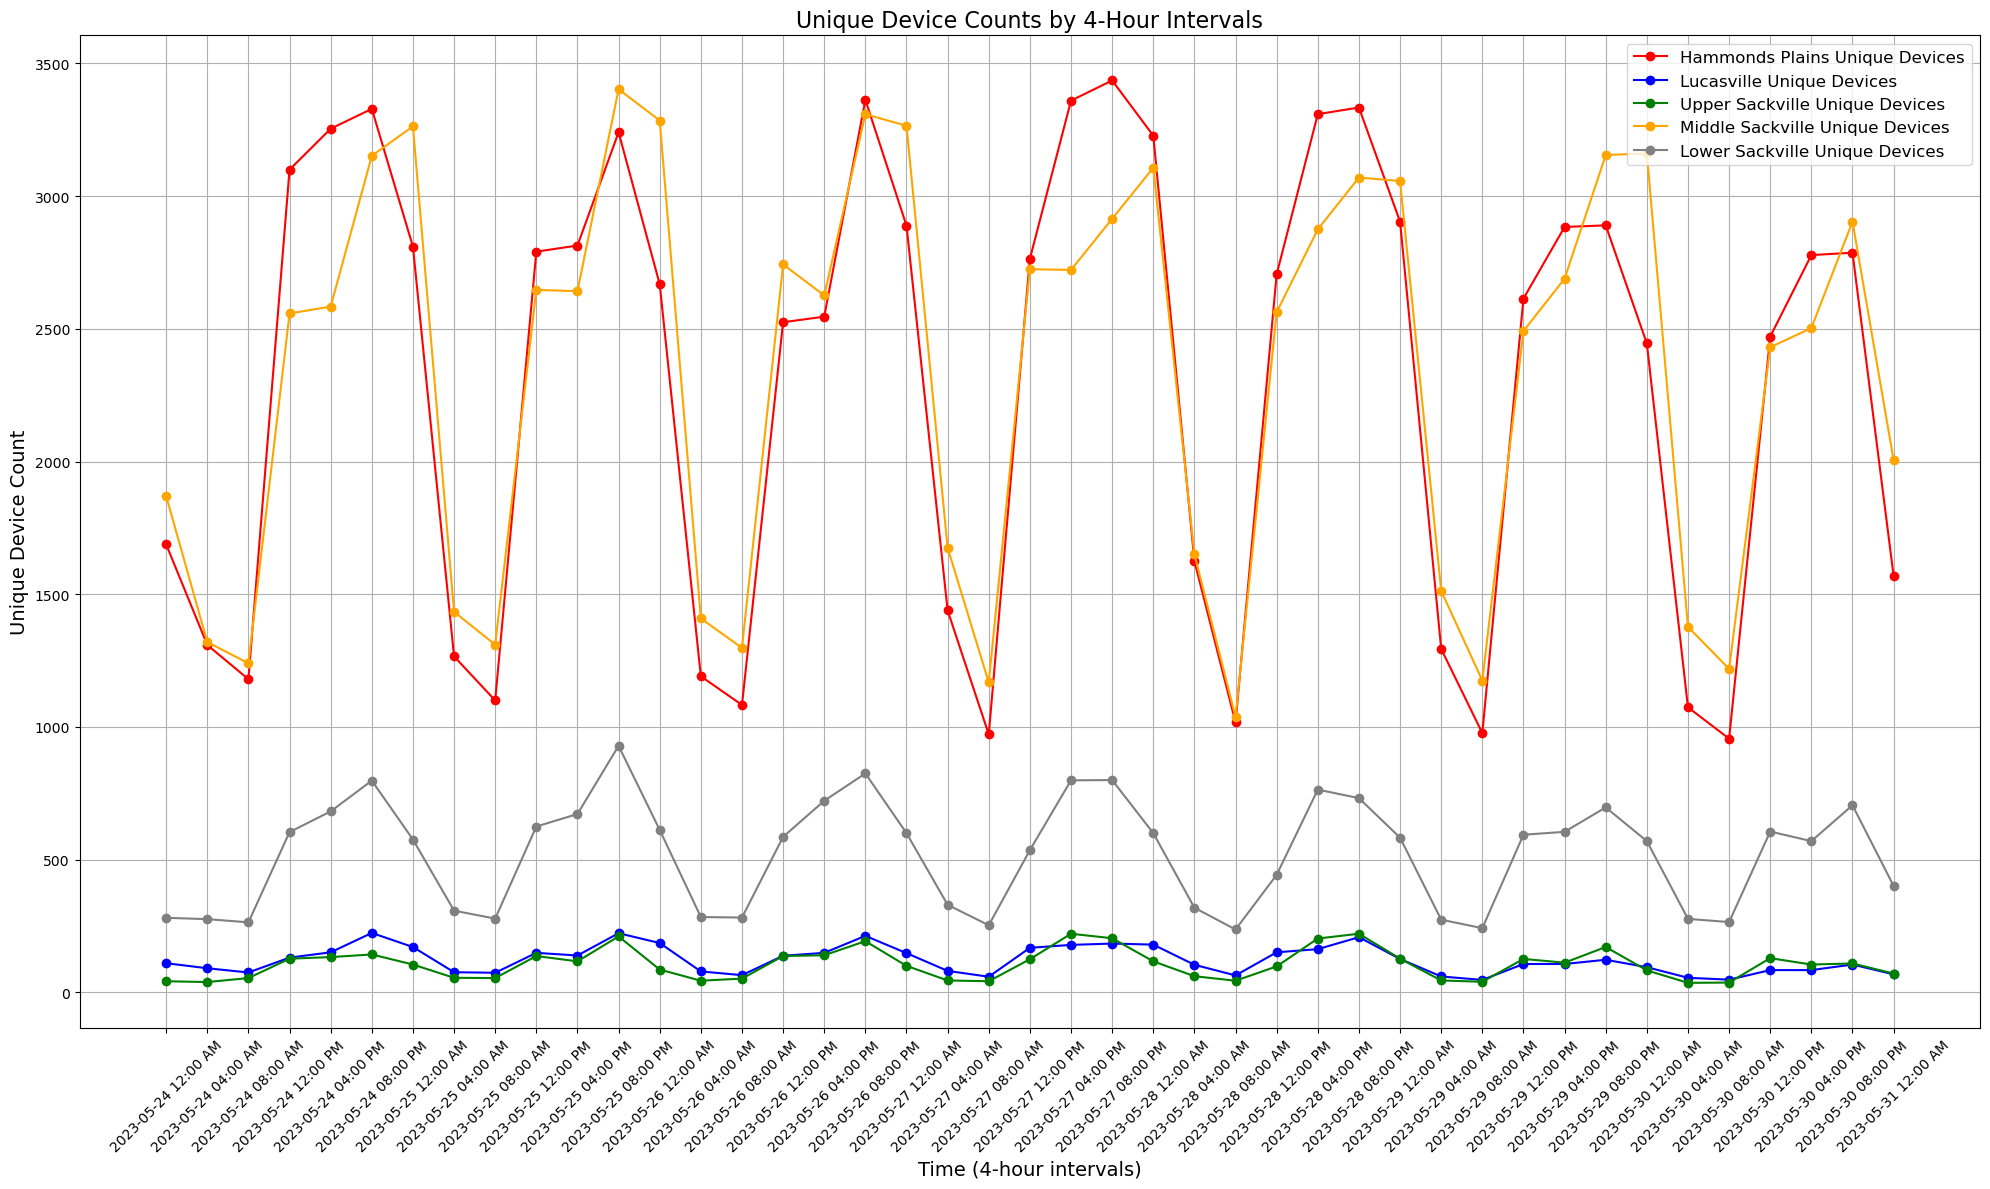

In [ ]:
# Compute unique counts for each dataframe
halifax_gps_24May_30May_ham_plains_unique_counts = halifax_gps_24May_30May_ham_plains.groupby('DateTimeApprox')['registrationID'].nunique()
halifax_gps_24May_30May_lucasville_unique_counts = halifax_gps_24May_30May_lucasville.groupby('DateTimeApprox')['registrationID'].nunique()
halifax_gps_24May_30May_upr_sville_unique_counts = halifax_gps_24May_30May_upr_sville.groupby('DateTimeApprox')['registrationID'].nunique()
halifax_gps_24May_30May_mid_sville_unique_counts = halifax_gps_24May_30May_mid_sville.groupby('DateTimeApprox')['registrationID'].nunique()
halifax_gps_24May_30May_low_sville_unique_counts = halifax_gps_24May_30May_low_sville.groupby('DateTimeApprox')['registrationID'].nunique()

# Create the plot
plt.figure(figsize=(20, 12))

plt.plot(
    halifax_gps_24May_30May_ham_plains_unique_counts.index,
    halifax_gps_24May_30May_ham_plains_unique_counts.values,
    label='Hammonds Plains Unique Devices',
    color='red',
    marker='o'
)
plt.plot(
    halifax_gps_24May_30May_lucasville_unique_counts.index,
    halifax_gps_24May_30May_lucasville_unique_counts.values,
    label='Lucasville Unique Devices',
    color='blue',
    marker='o'
)
plt.plot(
    halifax_gps_24May_30May_upr_sville_unique_counts.index,
    halifax_gps_24May_30May_upr_sville_unique_counts.values,
    label='Upper Sackville Unique Devices',
    color='green',
    marker='o'
)
plt.plot(
    halifax_gps_24May_30May_mid_sville_unique_counts.index,
    halifax_gps_24May_30May_mid_sville_unique_counts.values,
    label='Middle Sackville Unique Devices',
    color='orange',
    marker='o'
)
plt.plot(
    halifax_gps_24May_30May_low_sville_unique_counts.index,
    halifax_gps_24May_30May_low_sville_unique_counts.values,
    label='Lower Sackville Unique Devices',
    color='grey',
    marker='o'
)

# Add title and labels
plt.title("Unique Device Counts by 4-Hour Intervals", fontsize=16)
plt.xlabel('Time (4-hour intervals)', fontsize=14)
plt.ylabel('Unique Device Count', fontsize=14)

plt.xticks(
    halifax_gps_24May_30May_ham_plains_unique_counts.index,
    halifax_gps_24May_30May_ham_plains_unique_counts.index.strftime('%Y-%m-%d %I:%M %p'),
    rotation=45,
    fontsize=10
)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
